In [2]:
import numpy as np
import string
import pickle

In [ ]:
#This function parses and preprocesses the data and puts them into data structures that can be utilized for the further processing.
#Input : path of training_data_file/ validation_data_file/ testing_data_file ( These files can be downloaded  from link provided in README)
#output: list of instances, where each instance has 4 lists, representing [words][pos][phrase_chunks][labels]
def process_data_file(file_name):
    f = open(file_name, "r")
    tokens = []
    pos = []
    chunks = []
    ner_lables = []
    data = []
    for line in  f:
        if line == "\n" or line.startswith('-DOCSTART'):
            if len(tokens) > 0:
                sent = []
                sent.append(tokens)
                sent.append(pos)
                sent.append(chunks)
                sent.append(ner_lables)
                data.append(sent)

                # refresh the arrays
                tokens = []
                pos = []
                chunks = []
                ner_lables = []

        else:
            try:
                parts = line.strip("\n").split(" ")
                tokens.append(parts[0])
                pos.append(parts[1])
                chunks.append(parts[2])
                ner_lables.append(parts[3])
            except Exception as e:
                print(e)

    #data = data[1:]
    data = np.asarray(data)
    print(data.shape)
    return data

In [54]:
data = process_data_file("NER-datasets/CONLL2003/train.txt")
valid_data = process_data_file("NER-datasets/CONLL2003/valid.txt")
test_data = process_data_file("NER-datasets/CONLL2003/test.txt")

(14040, 4)
(3249, 4)
(3452, 4)


In [211]:
data[2]

array([list(['BRUSSELS', '1996-08-22']), list(['NNP', 'CD']),
       list(['B-NP', 'I-NP']), list(['B-LOC', 'O'])], dtype=object)

In [4]:
# this function divides the data into batches equal size
# Input: training data (array of instances)
# Output: list of batches that are of equal size
def createEqualBatches(data):
    n_batches = 100
    batch_size = len(data) // n_batches
    #print(batch_size)
    indices = []
    for i in range(n_batches):
        indices.append(batch_size*(i+1))
    #print(indices)
    
    batches = []
    batch_len = []
    z = 0
    start = 0
    print(len(indices))
    for end in indices:
        #print("start, end", start, end)
        batches.append(data[start:end])
        start = end

    return batches

In [112]:
batches = createEqualBatches(data)
print(len(batches))

100
100


In [121]:
print(data[1])

[list(['Peter', 'Blackburn']) list(['NNP', 'NNP']) list(['B-NP', 'I-NP'])
 list(['B-PER', 'I-PER'])]


In [4]:
# Intializing some global vars
# Reads from the glove embedding file and loads the embeddings into a dictionary and stores them in a pickle file
#Input: glove embeddings file
#Output: pickled embeddings
# TO DO : MAKE A DIRECTORY "embeddings"
Embeddings = {}
word_emb_dim  = 50
embedding_file = "embeddings/glove.6B.50d.txt"
def LoadEmbeddings(embedding_file):
    global Embeddings, word_emb_dim
    f = open(embedding_file, "r", encoding= "utf-8", errors= "ignore")
    for line in f :
        tokens = line.strip("\n").split()
        word = tokens[0].lower()
        vec = tokens[1:]
        vec = " ". join(vec)
        Embeddings[word] = vec
    Embeddings["zero_vec"] = "0.0 " * word_emb_dim
    Embeddings["zero_vec"] = Embeddings["zero_vec"].rstrip()
    f.close()
    
    g = open ("embeddings/EmbedDict.pkl", "wb")
    pickle.dump(Embeddings, g)
    g.close()

In [5]:
LoadEmbeddings("embeddings/glove.6B.50d.txt")

In [55]:
GloveEmbeddings = {}
pos_emebddings = {}
max_words = 15
case_emb_dim = 8
pos_emb_dim = 40
num_classes =  10

# Loads the word embeddings into a dictionary
def load_word_embeddings():
    #load the embeddings from the pickle file
    global GloveEmbeddings
    f = open("embeddings/EmbedDict.pkl", "rb")
    GloveEmbeddings = pickle.load(f)
    f.close()

# gets the word features
# Input: List of words and left_over is an integer that says how much padding is required
# Output: list of feature vectors for the words/ sentence ( with pads)
def get_word_feat_vecs(words, left_over):
    global max_words, GloveEmbeddings
    #remove extra words
    #print(words, left_over)
    if left_over < 0:
        words = words[:max_words]
    elif(left_over > 0): #padding req
        for i in range(left_over):
            words.append("zero_vec")
    
    # now obtain the feature vector
    feat_vec = []
    for word in words:
        word = word.lower()
        try:
            glove_vec = []
            splits = GloveEmbeddings[word].split()
            #print(splits)
            for v in splits:
                glove_vec.append(float(v))
            #glove_vec = [float(v for v in GloveEmbeddings[word].split())]
        except:
            glove_vec = []
            splits = GloveEmbeddings["zero_vec"].split()
            #print(splits)
            for v in splits:
                glove_vec.append(float(v))
        feat_vec.append(glove_vec)
    return feat_vec

#Gets the case embedding (Also one of the features)
#Input : A single word
#Output: Case embedding for that
def  get_case_embeddings(word):
    global case_emb_dim
    case_map = {'numeric': 0, 'all_lower': 1, 'all_upper': 2, 'initial_upper': 3, 'other': 4, 'mainly_numeric': 5,
                    'contains_digit': 6, 'PADDED_TOKEN': 7}
    num_of_digits = 0
    for char in word:
        if char.isdigit():
            num_of_digits += 1
    number_part = float(num_of_digits/len(word))
    
    casing = 'other'
    
    if num_of_digits == len(word):
        casing = "numeric"
    elif number_part >= 0.5:
        casing = "mainly_numeric"
    elif num_of_digits > 0:
        casing = "contains_digit"
    elif word.isupper():
        casing = "all_upper"
    elif word.islower():
        casing = "all_lower"
    elif word[0].lower():
        casing = "initial_upper"
    elif word[0].lower() == "zero_vec":
        casing = "PADDING_TOKEN"
    
    case_vector = [0]*case_emb_dim
    case_vector[case_map[casing]] = 1
    
    return case_vector

###################### Create pickle files for  pos and label embeddings #####################

def create_pos_embeddings(data):
    print(len(data))
    pos_statistics = {}
    pos_set = []
    for instance in data:
        pos_tags = instance[1]
        #print(pos_tags)
        for tag in pos_tags:
            if tag in string.punctuation:
                tag = "PUNCT"
            try:
                pos_statistics[tag] = pos_statistics[tag] + 1
            except:
                pos_statistics[tag] = 1
    
    print(pos_statistics)
    for pos in pos_statistics:
        pos_set.append(pos)
    pos_set.append("PADDED_POS_TAG")
    
    print(pos_set)
    print(len(pos_set))
    pos_map = {}
    for pos_idx in range(len(pos_set)):
        pos_vec = [0]* len(pos_set)
        pos_vec[pos_idx] = 1
        pos_map[pos_set[pos_idx]] = pos_vec
    
    f = open("POSEmbeddings.pickle", "wb")
    pickle.dump(pos_map, f)
    f.close()
    
def create_label_embeddings(data):
    label_set = []
    label_statistics = {}
    for instance in data:
        labels = instance[3]
        for label in labels:
            try:
                label_statistics[label] = label_statistics[label] + 1
            except:
                label_statistics[label] = 1
    ############### COMMENT WHEN LABEL STATISTICS IS NOT NEEDED ##################
    print(label_statistics)
    total_count = 0
    for label in label_statistics:
        total_count += label_statistics[label]
    
    for label, count in label_statistics.items():
        print("{}: {}%".format(label, round((count/total_count)*100, 2)))
    #####################################################################################
#     for label in label_statistics:
#         label_set.append(label)
#     label_set.append("PADDED_LABEL")
#     print(label_set)
#     print(len(label_set))
    
#     label_map = {}
    
#     for label_idx in range(len(label_set)):
#         label_vec = [0] * len(label_set)
#         label_vec[label_idx] = 1
#         label_map[label_set[label_idx]] = label_vec
    
#     f = open("LabelEmbed.pickle", "wb")
#     pickle.dump(label_map, f)
#     f.close()
        

In [56]:
# Gives the class statistics for Train_Data, Valid_Data, Test_Data
create_label_embeddings(data)
print("\n")
create_label_embeddings(valid_data)
print("\n")
create_label_embeddings(test_data)
print("\n")

{'B-ORG': 6319, 'O': 169576, 'B-MISC': 3438, 'B-PER': 6600, 'I-PER': 4528, 'B-LOC': 7140, 'I-ORG': 3704, 'I-MISC': 1155, 'I-LOC': 1157}
B-ORG: 3.1%
O: 83.28%
B-MISC: 1.69%
B-PER: 3.24%
I-PER: 2.22%
B-LOC: 3.51%
I-ORG: 1.82%
I-MISC: 0.57%
I-LOC: 0.57%


{'O': 42757, 'B-ORG': 1340, 'B-LOC': 1837, 'B-MISC': 922, 'I-MISC': 346, 'B-PER': 1842, 'I-PER': 1307, 'I-LOC': 257, 'I-ORG': 750}
O: 83.25%
B-ORG: 2.61%
B-LOC: 3.58%
B-MISC: 1.8%
I-MISC: 0.67%
B-PER: 3.59%
I-PER: 2.54%
I-LOC: 0.5%
I-ORG: 1.46%


{'O': 38289, 'B-LOC': 1667, 'B-PER': 1616, 'I-PER': 1156, 'I-LOC': 257, 'B-MISC': 701, 'I-MISC': 214, 'B-ORG': 1660, 'I-ORG': 834}
O: 82.53%
B-LOC: 3.59%
B-PER: 3.48%
I-PER: 2.49%
I-LOC: 0.55%
B-MISC: 1.51%
I-MISC: 0.46%
B-ORG: 3.58%
I-ORG: 1.8%




In [8]:
create_label_embeddings(data) # Label Statistics
create_pos_embeddings(data)



['B-ORG', 'O', 'B-MISC', 'B-PER', 'I-PER', 'B-LOC', 'I-ORG', 'I-MISC', 'I-LOC', 'PADDED_LABEL']
10
14040
{'NNP': 34391, 'VBZ': 2426, 'JJ': 11831, 'NN': 23898, 'TO': 3469, 'VB': 4252, 'PUNCT': 25403, 'CD': 19702, 'DT': 13453, 'VBD': 8293, 'IN': 19064, 'PRP': 3163, 'NNS': 9903, 'VBP': 1436, 'MD': 1199, 'VBN': 4105, 'POS': 1553, 'JJR': 382, 'RB': 3975, 'FW': 166, 'CC': 3653, 'WDT': 506, 'PRP$': 1520, 'RBR': 163, 'VBG': 2585, 'EX': 136, 'WP': 528, 'WRB': 384, 'RP': 528, 'NNPS': 684, 'SYM': 439, 'RBS': 35, 'UH': 30, 'PDT': 33, "''": 35, 'LS': 13, 'JJS': 254, 'WP$': 23, 'NN|SYM': 4}
['NNP', 'VBZ', 'JJ', 'NN', 'TO', 'VB', 'PUNCT', 'CD', 'DT', 'VBD', 'IN', 'PRP', 'NNS', 'VBP', 'MD', 'VBN', 'POS', 'JJR', 'RB', 'FW', 'CC', 'WDT', 'PRP$', 'RBR', 'VBG', 'EX', 'WP', 'WRB', 'RP', 'NNPS', 'SYM', 'RBS', 'UH', 'PDT', "''", 'LS', 'JJS', 'WP$', 'NN|SYM', 'PADDED_POS_TAG']
40


In [221]:
#gives average length of the sentence in trainig  data, useful to fix on a sentence length
def average_sent_len(data):
    word_lens = []
    len_dict ={}
    for instance in data:
        words = instance[0]
        word_lens.append(len(words))
    print(float(sum(word_lens)/len(word_lens)))
    for length in word_lens:
        try:
            len_dict[length] += 1
        except:
            len_dict[length] = 1
    print(len_dict)

average_sent_len(data) #Average length of the snetences
        

14.502635327635328
{9: 894, 2: 1129, 30: 194, 31: 209, 33: 173, 25: 223, 40: 80, 28: 217, 37: 102, 27: 202, 1: 179, 26: 212, 35: 135, 39: 109, 34: 155, 15: 279, 16: 235, 10: 503, 32: 186, 12: 324, 8: 1056, 47: 21, 24: 221, 44: 45, 42: 64, 11: 407, 19: 195, 21: 213, 14: 293, 17: 233, 29: 216, 22: 217, 3: 586, 7: 904, 13: 354, 5: 751, 20: 214, 6: 625, 46: 27, 38: 98, 36: 124, 18: 198, 4: 770, 52: 11, 23: 210, 41: 72, 50: 15, 45: 40, 54: 4, 43: 52, 48: 18, 51: 10, 58: 2, 57: 3, 60: 2, 49: 13, 53: 3, 55: 5, 62: 2, 78: 1, 56: 1, 59: 2, 113: 1, 67: 1}


In [9]:
# Gives how many words are needded to be padded given max words a sentence can take is  15.
# Input: List of words [Represents a sentence]
# output: Padding required (Integer Value)
def remaining(words):
    global max_words
    word_count = len(words)
    left_over = max_words - word_count
    return left_over
# Gets label vectors
def get_label_vectors(data):
    global num_classes, max_words
    data_label_vectors = []
    f = open("LabelEmbed.pickle", "rb")
    label_map = pickle.load(f)
    f.close()
    
    for  instance in data:
        labels = instance[3]
        left_over = remaining(labels)
        if left_over < 0:
            #print("no pad")
            labels =  labels[:max_words]
        temp = []
        for label in labels:
            label_vec = label_map[label]
            temp.append(label_vec)
        if left_over > 0:
            #print("Padded")
            label_vec = [0] * num_classes
            label_vec[9] = 1
            for i in range(left_over):
                temp.append(label_vec)
        #print(len(temp))
        #print(np.asarray(temp).shape)
        data_label_vectors.append(temp)
    
    return data_label_vectors

In [10]:
data_label_vecs = get_label_vectors(data)
a = np.asarray(data_label_vecs)
print(a.shape)

(14040, 15, 10)


In [11]:
#gives case features
#Input: list of words, padding_req
#Output: list of case vectors

def get_case_feat_vecs(words, left_over):
    global case_emb_dim, max_words
    case_vecs = []
    if left_over < 0:
        words = words[:max_words]
    for word in words:
        case_embedding = get_case_embeddings(word)
        case_vecs.append(case_embedding)
    if left_over > 0:
        case_embedding = [0] * case_emb_dim
        case_embedding[7] = 1
        for i in range(left_over):
            case_vecs.append(case_embedding)
    return case_vecs
    
    

In [85]:
print(len(get_case_feat_vecs(data)))

TypeError: get_case_feat_vecs() missing 1 required positional argument: 'left_over'

In [12]:
def load_pos_embeddings():
    global pos_embeddings
    f = open("POSEmbeddings.pickle", "rb")
    pos_embeddings = pickle.load(f)
    f.close()
    
def get_pos_feat_vecs(pos, left_over):
    global pos_embeddings, pos_emb_dim, max_words
    pos_vecs = []
    if left_over < 0:
        pos = pos[:max_words]
    for tag in pos:
        if tag in string.punctuation:
            tag = "PUNCT"
        pos_vec = pos_embeddings[tag]
        pos_vecs.append(pos_vec)
    if left_over > 0:
        pos_vec = pos_embeddings["PADDED_POS_TAG"]
        for i in range(left_over):
            pos_vecs.append(pos_vec)
    return pos_vecs
        
    

In [87]:
load_pos_embeddings()

In [13]:
def get_feature_vectors(data):
    ## This function gets the feature vectors (word, case and pos) for the entire training data ###
    
    # get feats for words
    global max_words
    data_word_feats = []
    data_case_feats = []
    data_pos_feats = []
    load_word_embeddings()
    load_pos_embeddings()
    for instance in data:
        tokens = instance[0]
        pos = instance[1]
#         if (len(tokens) != len(pos)):
#             print("WRONG")
#             print(tokens)
#             print(pos)
        left_over = remaining(tokens)
        
       
        #get feats for POS
        pos_feat_vecs = get_pos_feat_vecs(pos, left_over)
        data_pos_feats.append(pos_feat_vecs)
        #get feats for case
        case_feat_vecs = get_case_feat_vecs(tokens, left_over)
        data_case_feats.append(case_feat_vecs)
        #get for words
        words_feat_vecs = get_word_feat_vecs(tokens, left_over)
        data_word_feats.append(words_feat_vecs)
        
       
    
    return data_word_feats, data_case_feats, data_pos_feats
        
        

In [14]:
from keras.models import Sequential, Model, load_model, save_model
from keras.layers import Bidirectional, LSTM, Dense, Activation, Input, concatenate, TimeDistributed
def Build_Model(sent_max_words = 15, word_emb_dim = 50 , case_emb_dim = 7, pos_emb_dim = 46):
    lstm_dim = 200
    global num_classes
    #word input
    word_input = Input(shape=(sent_max_words, word_emb_dim))
    #case input
    case_input = Input(shape=(sent_max_words, case_emb_dim))
    #pos_input
    pos_input = Input(shape=(sent_max_words, pos_emb_dim))
    #Concatenate the three inputs
    merged_input = concatenate([word_input, case_input, pos_input])
    #pass the merged input to a BiLSTM
    lstm_output = Bidirectional(LSTM(lstm_dim, return_sequences=True, dropout = 0.2),merge_mode=None)(merged_input)
    merged_output = concatenate([lstm_output[0], lstm_output[1]], axis = 2)
    #Add a Time Distributed Layer
    output = TimeDistributed(Dense(num_classes, activation = "softmax"), name = "Softmax_Layer")(merged_output)
    
    ## Model ##
    model = Model(inputs = [word_input, case_input, pos_input], outputs = output)
    model.summary()
    
    return model
    
    
    
    

Using TensorFlow backend.


In [15]:
Build_Model()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 15, 50)       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 15, 7)        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 15, 46)       0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 15, 103)      0           input_1[0][0]                    
                                                                 input_2[0][0]                    
          

In [108]:
# Do not RUN #
#get epoch wise train error and validation error
import numpy as np
def train_model(data):
    print(data.shape)
    global max_words, word_emb_dim, case_emb_dim, pos_emb_dim, num_classes
    total_epochs = 30
    batch_size = 149 #equal batches
    #batches = createEqualBatches(data)
    model = Build_Model(max_words, word_emb_dim, case_emb_dim, pos_emb_dim)
    model.compile(loss= "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
    train_label_vectors = get_label_vectors(data)
    word_feats, case_feats, pos_feats =  get_feature_vectors(data)
    #print(len(word_feats), len(case_feats), len(pos_feats))
    
    print(len(train_label_vectors))
    
    #Metrics for each epoch
    word_feats = np.asarray(word_feats)
    case_feats = np.asarray(case_feats)
    pos_feats = np.asarray(pos_feats)
    train_label_vectors = np.asarray(train_label_vectors)
    print(word_feats.shape)
    print(case_feats.shape)
    print(pos_feats.shape)
    print(train_label_vectors.shape)
    model.fit([word_feats, case_feats, pos_feats], train_label_vectors, batch_size = 149, validation_split = 0.2, initial_epoch=0, epochs = total_epochs)
#     for epoch in  range(total_epochs):
#         model.fit([word_feats, case_feats, pos_feats], train_label_vectors, batch_size = 149, validation_split = 0)

        

train_model(data)

    
    

(14040, 4)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 15, 50)       0                                            
__________________________________________________________________________________________________
input_23 (InputLayer)           (None, 15, 7)        0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           (None, 15, 39)       0                                            
__________________________________________________________________________________________________
concatenate_15 (Concatenate)    (None, 15, 96)       0           input_22[0][0]                   
                                                                 input_23[0][0]                   

ValueError: Error when checking target: expected Softmax_Layer to have 3 dimensions, but got array with shape (14040, 15)

In [21]:
#Parsing and preprocessing of the validation_data
#ALWAYS RUN BEFORE GETTING THE RESULTS AND TRAINING THE MODEL
data = process_data_file("NER-datasets/CONLL2003/train.txt")
valid_data = process_data_file("NER-datasets/CONLL2003/valid.txt")

(14040, 4)
(3249, 4)


In [17]:
#FOR THE PURPOSE OF USING SKLEARN
def convert_to_scalar(label_vectors):
    scalar_vec = []
    for sentence in label_vectors:
        labels = []
        for word in sentence:
            #print(word)
            idx = np.argmax(word)
            labels.append(idx)
        scalar_vec.append(labels)
    scalar_vec = np.asarray(scalar_vec)
    
    return scalar_vec

In [22]:
#get epoch wise train error and validation error
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, classification_report
def train_model(train_data, valid_data):
    print(train_data.shape)
    print(valid_data.shape)
    global max_words, word_emb_dim, case_emb_dim, pos_emb_dim, num_classes
    total_epochs = 50
    batch_size = 149 #equal batches
    #batches = createEqualBatches(data)
    model = Build_Model(max_words, word_emb_dim, case_emb_dim, pos_emb_dim)
    model.compile(loss= "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
    train_label_vectors = get_label_vectors(train_data)
    train_word_feats, train_case_feats, train_pos_feats =  get_feature_vectors(train_data)
    
    valid_label_vectors = get_label_vectors(valid_data)
    valid_word_feats, valid_case_feats, valid_pos_feats =  get_feature_vectors(valid_data)
    
    
    #Conversion to numpy arrays (train)
    train_word_feats = np.asarray(train_word_feats)
    train_case_feats = np.asarray(train_case_feats)
    train_pos_feats = np.asarray(train_pos_feats)
    train_label_vectors = np.asarray(train_label_vectors)
    print(train_word_feats.shape, train_case_feats.shape, train_pos_feats.shape, train_label_vectors.shape)
    
    #conversion to numpy arrays (test)
    valid_word_feats = np.asarray(valid_word_feats)
    valid_case_feats = np.asarray(valid_case_feats)
    valid_pos_feats = np.asarray(valid_pos_feats)
    valid_label_vectors = np.asarray(valid_label_vectors)
    print(valid_word_feats.shape, valid_case_feats.shape, valid_pos_feats.shape, valid_label_vectors.shape)
    
    #valid_label_vectors =  convert_to_scalar(valid_label_vectors)
    
    
    
    best = 0.0
    model.fit([train_word_feats, train_case_feats, train_pos_feats], train_label_vectors, batch_size = batch_size, validation_data = ([valid_word_feats, valid_case_feats, valid_pos_feats],valid_label_vectors), initial_epoch=0, epochs = total_epochs)
    model.save("best_model2_ep_50.h5")
train_model(data, valid_data)

(14040, 4)
(3249, 4)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 15, 50)       0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 15, 8)        0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 15, 40)       0                                            
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 15, 98)       0           input_7[0][0]                    
                                                                 input_8[0][0]          

14040/14040 [==============================] - 20s 1ms/step - loss: 0.0042 - acc: 0.9990 - val_loss: 0.0573 - val_acc: 0.9876
Epoch 44/50
14040/14040 [==============================] - 21s 2ms/step - loss: 0.0038 - acc: 0.9991 - val_loss: 0.0568 - val_acc: 0.9878
Epoch 45/50
14040/14040 [==============================] - 21s 1ms/step - loss: 0.0037 - acc: 0.9992 - val_loss: 0.0592 - val_acc: 0.9871
Epoch 46/50
14040/14040 [==============================] - 21s 1ms/step - loss: 0.0036 - acc: 0.9992 - val_loss: 0.0586 - val_acc: 0.9878
Epoch 47/50
14040/14040 [==============================] - 21s 1ms/step - loss: 0.0037 - acc: 0.9991 - val_loss: 0.0584 - val_acc: 0.9874
Epoch 48/50
14040/14040 [==============================] - 21s 1ms/step - loss: 0.0035 - acc: 0.9991 - val_loss: 0.0584 - val_acc: 0.9876
Epoch 49/50
14040/14040 [==============================] - 21s 1ms/step - loss: 0.0034 - acc: 0.9992 - val_loss: 0.0572 - val_acc: 0.9878
Epoch 50/50
14040/14040 [=====================

In [57]:
#Parsing and preprocessing of the training_data
valid_data = process_data_file("NER-datasets/CONLL2003/valid.txt")
test_data = process_data_file("NER-datasets/CONLL2003/test.txt")

(3249, 4)
(3452, 4)


In [59]:
def exlude_padded_class(scalar_label_vectors):
    new_scalar_label_vectors = []
    for instance in scalar_label_vectors:
        temp = []
        for label in instance:
            if label != 9:
                temp.append(label)
        new_scalar_label_vectors.append(temp)
    new_scalar_label_vectors = np.asarray(new_scalar_label_vectors)
    return new_scalar_label_vectors
    

In [234]:
# FIRST RUN ON VALIDATION DATA ##### ###### NOT THE FINAL MODEL ###########
from sklearn.metrics import classification_report
def metric(model_file, test_data):
    model = load_model(model_file)
    test_label_vectors = get_label_vectors(test_data)
    test_word_feats, test_case_feats, test_pos_feats =  get_feature_vectors(test_data)
    predicted_label_vectors = model.predict(([test_word_feats, test_case_feats, test_pos_feats]))
    test_label_vectors =  convert_to_scalar(test_label_vectors)
    #test_label_vectors = exlude_padded_class(test_label_vectors)
    
    predicted_label_vectors = convert_to_scalar(predicted_label_vectors)
    
    #predicted_label_vectors = exlude_padded_class(predicted_label_vectors)
    #labels = ['B-ORG', 'O', 'B-MISC', 'B-PER', 'I-PER', 'B-LOC', 'I-ORG', 'I-MISC', 'I-LOC', 'PADDED_LABEL']
    
    cf = confusion_matrix(test_label_vectors.ravel(), predicted_label_vectors.ravel())
    print(cf)
#     macro_score = f1_score(test_label_vectors.ravel(), predicted_label_vectors.ravel(), average='macro')
#     micro_score = f1_score(test_label_vectors.ravel(), predicted_label_vectors.ravel(), average='micro')
#     weighted_score = f1_score(test_label_vectors.ravel(), predicted_label_vectors.ravel(), average='weighted')
#     print(macro_score, micro_score, weighted_score)
    cf_report = classification_report(test_label_vectors.ravel(), predicted_label_vectors.ravel(), target_names= ['B-ORG', 'O', 'B-MISC', 'B-PER', 'I-PER', 'B-LOC', 'I-ORG', 'I-MISC', 'I-LOC', 'PADDED_LABEL'])
    return cf_report

model_file = "best_model2.h5"
cf_report = metric(model_file,valid_data)
print(cf_report)

[[  953    31    14    25     0    31    11     3     0     0]
 [   27 26904    24    10     3    10    16    12     1     0]
 [   21    40   550     9     0    21     2     2     1     0]
 [    2     7     3  1335     9     9     2     0     0     0]
 [    0    15     0     7   874     0     0     0     0     0]
 [   26     9     6    14     1  1337     1     1     2     0]
 [    5    32     0     1    13     3   450     4    14     0]
 [    0    36    11     1     2     1    11   171     4     0]
 [    0     4     0     0     3     4    10     3   164     0]
 [    0     0     0     0     0     0     0     0     0 15407]]


In [239]:
#Removing the padded_token class the over_all precision, recall and f-score of the system is as follows:
Validation Data
Precision: 91.67
Recall: 90.12
F-score: 91.23

              precision    recall  f1-score   support

       B-ORG       0.92      0.89      0.91      1068
           O       0.99      1.00      0.99     27007
      B-MISC       0.90      0.85      0.88       646
       B-PER       0.95      0.98      0.96      1367
       I-PER       0.97      0.98      0.97       896
       B-LOC       0.94      0.96      0.95      1397
       I-ORG       0.89      0.86      0.88       522
      I-MISC       0.87      0.72      0.79       237
       I-LOC       0.88      0.87      0.88       188
PADDED_LABEL       1.00      1.00      1.00     15407

 avg / total       0.99      0.99      0.99     48735



In [45]:
def metric(model_file, test_data):
    model = load_model(model_file)
    test_label_vectors = get_label_vectors(test_data)
    test_word_feats, test_case_feats, test_pos_feats =  get_feature_vectors(test_data)
    predicted_label_vectors = model.predict(([test_word_feats, test_case_feats, test_pos_feats]))
    test_label_vectors =  convert_to_scalar(test_label_vectors)
    predicted_label_vectors = convert_to_scalar(predicted_label_vectors)
    cf = confusion_matrix(test_label_vectors.ravel(), predicted_label_vectors.ravel())
    print(cf)
#     macro_score = f1_score(test_label_vectors.ravel(), predicted_label_vectors.ravel(), average='macro')
#     micro_score = f1_score(test_label_vectors.ravel(), predicted_label_vectors.ravel(), average='micro')
#     weighted_score = f1_score(test_label_vectors.ravel(), predicted_label_vectors.ravel(), average='weighted')
#     print(macro_score, micro_score, weighted_score)
    print(classification_report(test_label_vectors.ravel(), predicted_label_vectors.ravel(), target_names= ['B-ORG', 'O', 'B-MISC', 'B-PER', 'I-PER', 'B-LOC', 'I-ORG', 'I-MISC', 'I-LOC', 'PADDED_LABEL']))

model_file = "best_model2_ep_50.h5"
metric(model_file,test_data)

[[ 1197    46    47    20     0    48    12     1     1     0]
 [   36 25767    92    29     2    34    24    51    18     0]
 [   31    32   411    12     0    21     1     4     0     0]
 [   23    21     3  1184     8    18     0     0     1     0]
 [    0     3     0     2   817     0     7     1     3     0]
 [   46    10    23    10     1  1234     1     1     3     0]
 [   31    47     2     1    10     5   479    10    23     0]
 [    0    25     6     1     3     0    14   100     4     0]
 [    0     7     1     0     1     5     8     0   182     0]
 [    0     0     0     0     0     0     0     0     0 19458]]
              precision    recall  f1-score   support

       B-ORG       0.88      0.87      0.88      1372
           O       0.99      0.99      0.99     26053
      B-MISC       0.70      0.80      0.75       512
       B-PER       0.94      0.94      0.94      1258
       I-PER       0.97      0.98      0.98       833
       B-LOC       0.90      0.93      0.92 

In [ ]:
#Removing the padded_token class the over_all precision, recall and f-score of the system is as follows:
Test Data
# batch_size = 149, epochs = 30
Precision: 84.67
Recall: 85.56
F1-score: 85

# batch size = 256 , epochs = 30
Test Data
Precision: 84.3
Recall: 85.78
F1-score: 85.23

# batch size = 149, epochs = 50
Test Data
Precision: 84.78
Recall: 87.12
F1-score: 86


In [25]:
import string
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [33]:
def collapse_classes(ravel_label_vec):
    new_label_vec = []
    for label in ravel_label_vec:
        if label == 6 or label == 0:
            label = 0
        elif label == 7 or label == 2:
            label = 2
        elif label == 4 or label == 3:
            label = 3
        elif label == 8 or label == 5:
            label = 4
        elif label == 9:
            label = 5
        new_label_vec.append(label)
    new_label_vec = np.asarray(new_label_vec)
    return new_label_vec   

In [53]:
def metric(model_file, test_data):
    model = load_model(model_file)
    test_label_vectors = get_label_vectors(test_data)
    test_word_feats, test_case_feats, test_pos_feats =  get_feature_vectors(test_data)
    predicted_label_vectors = model.predict(([test_word_feats, test_case_feats, test_pos_feats]))
    test_label_vectors =  convert_to_scalar(test_label_vectors)
    predicted_label_vectors = convert_to_scalar(predicted_label_vectors)
    
    test_label_vectors = collapse_classes(test_label_vectors.ravel())
    predicted_label_vectors = collapse_classes(predicted_label_vectors.ravel())
    cf = confusion_matrix(test_label_vectors.ravel(), predicted_label_vectors.ravel())
    print(cf)
    target_names = ['ORG', 'O', 'MISC', 'PER','LOC', 'PADDED_CLASS']
    print(classification_report(test_label_vectors, predicted_label_vectors, target_names = target_names))
    return cf

model_file = "best_model2_ep_50.h5"
cf = metric(model_file,test_data)

[[ 1719    93    60    31    77     0]
 [   60 25767   143    31    52     0]
 [   46    57   521    16    25     0]
 [   30    24     4  2011    22     0]
 [   55    17    25    12  1424     0]
 [    0     0     0     0     0 19458]]
              precision    recall  f1-score   support

         ORG       0.90      0.87      0.88      1980
           O       0.99      0.99      0.99     26053
        MISC       0.69      0.78      0.73       665
         PER       0.96      0.96      0.96      2091
         LOC       0.89      0.93      0.91      1533
PADDED_CLASS       1.00      1.00      1.00     19458

 avg / total       0.98      0.98      0.98     51780



In [ ]:
#for 50 epochs and a batch size of 149 (Overall System Precision, Recall and F1-score)
Test Data
Precision: 84.78
Recall: 87.12
F1-score: 86

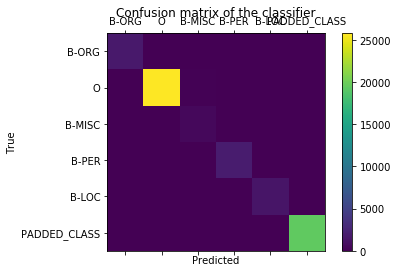

In [60]:
#Plot a confusion Matrix
from matplotlib import pyplot as plt
labels = ['B-ORG', 'O', 'B-MISC', 'B-PER','B-LOC', 'PADDED_CLASS']
#cm = confusion_matrix(y_test, pred, labels)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cf)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()